In [1]:
from datetime import datetime
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn import metrics

from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric

import shap
import xgboost as xgb
import pickle
import graphviz
from tableone import TableOne, load_dataset
from IPython.display import Latex

from counterfactuals import *

C:\Users\boris\anaconda3\envs\INNO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shap.initjs()
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# XAI-trust overzicht explanations

Dit notebook dient als toelichting bij alle explanations die het XAI-trust project gemaakt heeft aan de hand van een model dat sepsis-geassocieerd delirium voorspelt. Het is niet nodig om de paper over het model te lezen, maar kan wellicht wel context bieden: https://doi.org/10.1038/s41598-023-38650-4

In de markdown cellen staat informatie over hoe de explanation afgelezen dient te worden. Sommige stukjes code zijn voorzien van comments die hulp kunnen bieden bij de implementatie op de dashboard.  

# **Table Of Contents**
- [DATA PREP + MODELLEN](#1)
- [GLOBAL EXPLANATIONS](#2)
  - [TableOne](#2.1)
  - [Correlation Matrix](#2.1b)
  - [Confusion Matrix](#2.2)
  - [XGB functionality](#2.3)
    - [Feature importance](#2.3.1)
    - [Graphviz](#2.3.2)
  - [SHAP](#2.4)
    - [Interactive](#2.4.1)
    - [Bar](#2.4.2)
    - [Beeswarm](#2.4.3)
  - [Data Drift](#2.5)
- [LOCAL EXPLANATIONS](#3)
  - [Counterfactuals](#3.1)
    - [Feature select](#3.1.1)
    - [Genetic](#3.1.2)
    - [KDTree](#3.1.3)
  - [SHAP](#3.2)
    - [Force](#3.2.1)
    - [Waterfall](#3.2.3)
    - [Decision](#3.2.2)


# **Glossary**

**Categoriaal**: Wanneer een feature categoriaal is kunnen we de waarden van die feature niet sorteren op grootte. Een feature 'haarkleur' zou bijvoorbeeld categoriaal zijn.

**Correlatie**: Ook wel '**lineair verband**'. Wanneer twee features een lineaire relatie hebben verwacht je dat een verandering in één variabele een constante verandering in de andere variabele veroorzaakt. 

**Data drift**: ook wel '**Model Drift**'. Een model wordt getraind op een set op een bepaald moment, maar de echte wereld veranderd constant; een populatie kan bijvoorbeeld ouder worden, een ecosysteem kan opwarmen, medische techniek kan verbeteren. De mate waarin een model niet meer past op de nieuwe werkelijkheid (dus de mate waarin de *test set* en de *huidige set* van elkaar afwijken) noemen we data drift

**(Data)set**: Grote hoeveelheid gegevenspunten, denk bijvoorbeeld aan een excel sheet.
vaak bij het trainen van een machine learning model wordt een set opgedeeld in een test- en een train set
- **traintset**: set met data waarop het getraind wordt
- **testset**: set die gebruikt wordt om het model te valideren

**(Decision)tree**: Ook wel '**keuzeboom**'. Het is als het ware een soort flowchart (zie 'split') die wordt afgelopen om tot een predictie te komen. XGBoost bestaat uit meerdere decisiontrees die samen tot een voorspelling komen.

**Feature**: Een kenmerk of eigenschap, aan de hand waarvan wij een voorspelling kunnen maken. Als wij bijvoorbeeld de prijs van een huis willen voorspellen dan kan het woonoppervlak een feature daarvoor zijn.

**Kolom**: Verticale opeenvolging van informatie-cellen in tabel.

**Leave**: Als het ware een 'eindpunt' van een decision tree; de keuze waar die op land.

**Machine learning**: Subcategorie van artificial intelligence. Waar artificial intelligence ook een 'dom' algoritme kan zijn zoals bijvoorbeeld een NPC in een spel, duidt machine learning specifiek op een algoritme wat kan leren. 

**Mean**: Engels voor **gemiddelde**; het totaal van gegevenspunten gedeeld door het aantaantal gegevenspunten.

**Missing**: Ontbrekende waarden worden zo aangegeven. In een set staat het ook vaak aangegeven als '**NaN**' of '**None**'

**Model**: Een algoritme dat de echte wereld probeert na te bootsen, als het ware probeert te modelleren. In ons geval hebben we een XGBoost model getrains op een hele hoop patiënten met en zonder SAD, zodat als wij een niewe patiënt aandragen het algoritme modelleert of de nieuwe patient SAD heeft.

**N**: Wordt vaak gebruikt om een discrete grootheid aan te geven. Bijvoorbeeld in een onderzoek waarbij 500 meetpunten genomen zijn kan er 'n = 500' staan. 

**Ordinaal**: Wanneer een feature ordinaal is, kunnen we diens waarden sorteren naar grootte. Bijvoorbeeld een feature 'leeftijd' is ordinaal want we kunnen stellen de leeftijd 45 'groter' is dan de leeftijd 32.

**Proxy**: Wanneer een feature een proxy is voor een ander, dan is die feature een indirecte indicatie van de ander. Bijvoorbeeld een feature 'burgerlijke staat' zou een proxy kunnen zijn voor een feature 'leeftijd', iemands burgerlijke staat is immers een indicatie van iemands leeftijdscategorie.

**Record**: Hier mee wordt meestal een rij in een dataset bedoeld.

**Rij**: Horizontale opeenvolging van informatie-cellen in tabel. 

**Sample**: In dit document wordt hier meestal een subset van de dataset bedoeld.

**Sepsis associated delirium**: Vaak afgekort als '**SAD**', de aandoening die ons model probeert te voorspellen. Soms in dit notebook wordt 'SAD' gebruikt als indicatie dat iemand SAD positief is en 'NON-SAD' als de voorspelling negatief is.

**SHAP waarde**: Mate waarin een bepaalde feature bijdraagt aan een bepaalde voorspelling. SHAP is kort voor **SHapley Additive exPlanations**

**Split**: Binnen een decision tree maak je keuzes aan de hand van een waarde van een feature. Stel je voor we maken een flowchart om het weer te bepalen, je zou dan een keuzemoment hebben waarop je bepaald of het regent of niet; de 'feature' regen kan de 'waarde' *wel* of *niet* aannemen. Deze keuze binnen een keuzeboom noemen we een split.  

**Standaarddeviatie**: Vaak afgekort als '**SD**', een maat voor de spreiding van gegevenspunten in een dataset rondom het gemiddelde. Een hoge standaarddeviatie indiceert een hoge spreiding van de data.

**Verwachtingswaarde**: Ook wel **gewogen gemiddelde**. De waarde die een datapunt gemiddeld aanneemt. Bijvoorbeeld als we een normale dobbelsteen gooien is het gemiddelde van de ogen 3.5 dus de verwachtingswaarde is ook 3.5. Als we een gewogen dobbelsteen gooien waarbij de 6 twee keer zo vaak voorkomt, is het gemiddelde van de ogen nog steeds 3.5, maar de gemiddelde waarde ligt hoger dus de verwachtingswaarde is (1+2+3+4+5+2*6)/7 = 3.86.

**X**: Invoerwaarde van een functie. Wanneer het gaat om modellen die grote hoeveelheden data tegelijk verwerken kan 'X' dus ook staan voor een hele dataset die in een keer in het model gestopt wordt

**XGBoost**: Een machine learning model die meerdere decision trees genereert. Aan de hand van de decision trees komt het model tot diens predictie.

**y**: Uitvoerwaarde van een functie. In ons geval is dat dus de predictie, dus of iemand wel of geen SAD heeft.

# **DATA + MODELLEN** <a class="anchor" id="1"></a>

In [3]:
data_raw = pd.read_stata('MIMIC-SAD_dta_files/MIMIC-IV.dta')
data_cf = data_raw.drop(['deliriumtime', 'hosp_mort', 'icu28dmort', 'stay_id', 'icustay', 'hospstay', 'sepsistime'], axis=1).dropna()
dummies = pd.get_dummies(data_cf['race'])
data = data_cf.drop('race',axis=1).join(dummies)
dummies = pd.get_dummies(data['first_careunit'])
data = data.drop('first_careunit',axis=1).join(dummies)
xgb_matrix = xgb.DMatrix(data.drop(['sad'], axis=1))

data_cf = data_cf.drop(['sad'], axis=1)

data_table = data_raw.drop('stay_id', axis=1)
data_table['gender'] = data_table['gender'].replace(to_replace = 0.0, value = 'FEMALE')
data_table['gender'] = data_table['gender'].replace(to_replace = 1.0, value = 'MALE')

data_table['sad'] = data_table['sad'].replace(to_replace = 0.0, value = 'NON-SAD')
data_table['sad'] = data_table['sad'].replace(to_replace = 1.0, value = 'SAD')

for i in ['vent', 'crrt', 'vaso', 'seda', 'ami', 'ckd', 'copd', 'hyperte', 'dm', 'aki', 'stroke','hosp_mort']:
    data_table[i] = data_table[i].replace(to_replace = 0.0, value = 'FALSE')
    data_table[i] = data_table[i].replace(to_replace = 1.0, value = 'TRUE')

**`data_raw`**: data direct uit het .dta bestand van de SAD repo

In [4]:
data_raw

stay_id   age      weight  gender   race first_careunit  temperature  \
0      30000646  44.0   79.000000       0  AISAN            CCU    37.000000   
1      30001446  56.0  119.300003       0  WHITE           MICU    36.720001   
2      30002415  73.0   83.500000       1  WHITE          CVICU    36.439999   
3      30003226  67.0   93.449997       0  BLACK           SICU    37.220001   
4      30004242  76.0   77.599998       1  BLACK          TSICU    36.720001   
...         ...   ...         ...     ...    ...            ...          ...   
14615  39993425  93.0   47.799999       1  WHITE           MICU    35.830002   
14616  39993476  67.0   93.000000       0  WHITE          CVICU    36.439999   
14617  39993968  91.0   57.500000       1  WHITE            CCU    35.830002   
14618  39996044  59.0   66.400002       0  WHITE           MICU    36.389999   
14619  39999301  78.0  107.699997       0  BLACK          CVICU    36.610001   

       heart_rate  resp_rate   spo2    sbp   dbp   mbp   wbc  hemoglobin  \
0           100.0       28.0   98.0  107.0  66.0  75.0   8.5        12.9   
1            82.0       22.0   90.0   75.0  56.0  61.0  13.0         7.2   
2            71.0       16.0  100.0  117.0  67.0  87.0   6.7        10.4   
3            89.0       17.0   98.0  111.0  63.0  71.0   8.3         7.3   
4            59.0       21.0   97.0  107.0  90.0  94.0   9.4        11.0   
...           ...        ...    ...    ...   ...   ...   ...         ...   
14615       115.0       16.0   99.0   97.0  71.0  80.0   6.5        11.6   
14616        81.0       16.0  100.0  112.0  60.0  78.0  13.1        13.6   
14617        43.0       17.0  100.0   78.0  39.0  49.0  15.8        14.7   
14618       105.0       23.0  100.0  107.0  63.0  80.0   3.7         8.0   
14619        58.0       15.0   96.0  108.0  62.0  73.0   9.3        12.5   

       platelet   bun         cr    glu     Na     Cl    K   Mg   Ca    P  \
0         268.0  12.0   0.900000  102.0  138.0  105.0  3.5  2.2  7.8  3.4   
1          36.0  70.0   2.700000   83.0  128.0  103.0  4.0  2.2  7.0  4.5   
2          96.0   9.0   0.600000  170.0  136.0  111.0  4.5  3.2  NaN  NaN   
3         225.0  63.0  18.200001  117.0  135.0   93.0  6.8  1.9  8.6  6.2   
4         280.0  10.0   0.500000  123.0  136.0  100.0  3.3  1.5  9.1  3.6   
...         ...   ...        ...    ...    ...    ...  ...  ...  ...  ...   
14615     119.0  45.0   0.900000  121.0  152.0  119.0  3.6  2.3  8.1  2.8   
14616     166.0  12.0   0.700000  113.0  135.0  105.0  4.5  2.3  8.2  2.5   
14617     258.0  33.0   1.500000  177.0  132.0   98.0  5.3  2.0  8.8  5.1   
14618      15.0  20.0   0.500000  161.0  139.0  105.0  4.0  1.9  7.6  4.5   
14619     197.0  17.0   1.500000  114.0  142.0  109.0  3.4  2.1  8.8  3.4   

       inr         pt        ptt  bicarbonate  aniongap   gcs  vent  crrt  \
0      1.3  14.500000  37.400002         25.0      12.0  15.0   0.0   0.0   
1      2.1  22.400000  38.400002         15.0      14.0  15.0   0.0   0.0   
2      1.8  20.000000  37.700001         21.0       6.0  15.0   0.0   0.0   
3      NaN        NaN        NaN         24.0      25.0  15.0   0.0   1.0   
4      1.0  11.300000  24.900000         24.0      15.0  15.0   0.0   0.0   
...    ...        ...        ...          ...       ...   ...   ...   ...   
14615  1.7  18.299999  29.500000         19.0      13.0   8.0   0.0   0.0   
14616  1.2  13.300000  23.400000         24.0      10.0  15.0   1.0   0.0   
14617  1.0  12.400000  26.400000         23.0      16.0  15.0   0.0   0.0   
14618  1.3  13.900000  26.100000         26.0      12.0  15.0   1.0   0.0   
14619  1.1  13.400000  26.500000         24.0      12.0  15.0   0.0   0.0   

       vaso  seda  sofa_score  ami  ckd  copd  hyperte   dm  sad  aki  stroke  \
0       1.0   0.0           3  0.0  0.0   0.0      0.0  0.0  0.0  0.0     0.0   
1       1.0   0.0           8  0.0  0.0   0.0      0.0  0.0  0.0  1.0     0.0   
2       1.0   1.0           4  0.0  0.0  

**`data_cf`**: data voor counterfactual modellen (update: deprecated, counterfactuals debruikt nu `data`) (update 2: deze wordt nu wel gebruikt voor outlier detection)

- geen one-hot encoding
- NaN rijen gedropt
- ongebruikte features gedropt ('hosp_mort' etc.)
- target ('sad') gedropt

In [5]:
data_cf 

age      weight  gender   race first_careunit  temperature  \
0      44.0   79.000000       0  AISAN            CCU    37.000000   
1      56.0  119.300003       0  WHITE           MICU    36.720001   
4      76.0   77.599998       1  BLACK          TSICU    36.720001   
5      83.0   72.000000       0  WHITE           SICU    36.330002   
6      57.0   77.500000       0  WHITE           MICU    38.669998   
...     ...         ...     ...    ...            ...          ...   
14615  93.0   47.799999       1  WHITE           MICU    35.830002   
14616  67.0   93.000000       0  WHITE          CVICU    36.439999   
14617  91.0   57.500000       1  WHITE            CCU    35.830002   
14618  59.0   66.400002       0  WHITE           MICU    36.389999   
14619  78.0  107.699997       0  BLACK          CVICU    36.610001   

       heart_rate  resp_rate   spo2    sbp   dbp   mbp        wbc  hemoglobin  \
0           100.0       28.0   98.0  107.0  66.0  75.0   8.500000        12.9   
1            82.0       22.0   90.0   75.0  56.0  61.0  13.000000         7.2   
4            59.0       21.0   97.0  107.0  90.0  94.0   9.400000        11.0   
5           109.0       16.0  100.0  111.0  63.0  79.0   4.800000        13.3   
6           101.0       23.0   99.0  130.0  84.0  93.0  17.200001        15.1   
...           ...        ...    ...    ...   ...   ...        ...         ...   
14615       115.0       16.0   99.0   97.0  71.0  80.0   6.500000        11.6   
14616        81.0       16.0  100.0  112.0  60.0  78.0  13.100000        13.6   
14617        43.0       17.0  100.0   78.0  39.0  49.0  15.800000        14.7   
14618       105.0       23.0  100.0  107.0  63.0  80.0   3.700000         8.0   
14619        58.0       15.0   96.0  108.0  62.0  73.0   9.300000        12.5   

       platelet   bun   cr    glu     Na     Cl    K   Mg   Ca    P  inr  \
0         268.0  12.0  0.9  102.0  138.0  105.0  3.5  2.2  7.8  3.4  1.3   
1          36.0  70.0  2.7   83.0  128.0  103.0  4.0  2.2  7.0  4.5  2.1   
4         280.0  10.0  0.5  123.0  136.0  100.0  3.3  1.5  9.1  3.6  1.0   
5         307.0  62.0  2.8  108.0  136.0  108.0  3.6  2.1  6.4  4.1  1.4   
6         261.0  25.0  1.0  100.0  138.0  105.0  4.3  2.0  8.5  4.0  1.2   
...         ...   ...  ...    ...    ...    ...  ...  ...  ...  ...  ...   
14615     119.0  45.0  0.9  121.0  152.0  119.0  3.6  2.3  8.1  2.8  1.7   
14616     166.0  12.0  0.7  113.0  135.0  105.0  4.5  2.3  8.2  2.5  1.2   
14617     258.0  33.0  1.5  177.0  132.0   98.0  5.3  2.0  8.8  5.1  1.0   
14618      15.0  20.0  0.5  161.0  139.0  105.0  4.0  1.9  7.6  4.5  1.3   
14619     197.0  17.0  1.5  114.0  142.0  109.0  3.4  2.1  8.8  3.4  1.1   

              pt        ptt  bicarbonate  aniongap   gcs  vent  crrt  vaso  \
0      14.500000  37.400002         25.0      12.0  15.0   0.0   0.0   1.0   
1      22.400000  38.400002         15.0      14.0  15.0   0.0   0.0   1.0   
4      11.300000  24.900000         24.0      15.0  15.0   0.0   0.0   0.0   
5      16.200001  26.900000         18.0      14.0  15.0   1.0   0.0   1.0   
6      13.500000  33.799999         21.0      16.0  13.0   1.0   0.0   0.0   
...          ...        ...          ...       ...   ...   ...   ...   ...   
14615  18.299999  29.500000         19.0      13.0   8.0   0.0   0.0   1.0   
14616  13.300000  23.400000         24.0      10.0  15.0   1.0   0.0   0.0   
14617  12.400000  26.400000         23.0      16.0  15.0   0.0   0.0   1.0   
14618  13.900000  26.100000         26.0      12.0  15.0   1.0   0.0   1.0   
14619  13.400000  26.500000         24.0      12.0  15.0   0.0   0.0   0.0   

       seda  sofa_score  ami  ckd  copd  hyperte   dm  aki  stroke  
0       0.0           3  0.0  0.0   0.0      0.0  0.0  0.0     0.0  
1       0.0           8  0.0  0.0   0.0      0.0  0.0  1.0     0.0  
4       0.0           3  0.0  0.0   0.0      1.0  0.0  0.0     0.0  
5       1.0           3  0.0  0.0   0.0      1.0  0.0  1.0     0.0  

**`data_table`**: data voor TableOne en de correlatie matrix: een aantal features zijn aangepast om het aangenamer lezen te maken (bijv `1.0` vervangen voor `'TRUE'`, als het een boolean kolom is)

- geen one-hot encoding
- geen NaN rijen gedropt
- geen ongebruikte features gedropt, behalve 'stay_id': dit is een index; data-analyse hierop doen zou onzinnig zijn
- geen target gedropt

In [6]:
data_table

age      weight  gender   race first_careunit  temperature  \
0      44.0   79.000000  FEMALE  AISAN            CCU    37.000000   
1      56.0  119.300003  FEMALE  WHITE           MICU    36.720001   
2      73.0   83.500000    MALE  WHITE          CVICU    36.439999   
3      67.0   93.449997  FEMALE  BLACK           SICU    37.220001   
4      76.0   77.599998    MALE  BLACK          TSICU    36.720001   
...     ...         ...     ...    ...            ...          ...   
14615  93.0   47.799999    MALE  WHITE           MICU    35.830002   
14616  67.0   93.000000  FEMALE  WHITE          CVICU    36.439999   
14617  91.0   57.500000    MALE  WHITE            CCU    35.830002   
14618  59.0   66.400002  FEMALE  WHITE           MICU    36.389999   
14619  78.0  107.699997  FEMALE  BLACK          CVICU    36.610001   

       heart_rate  resp_rate   spo2    sbp   dbp   mbp   wbc  hemoglobin  \
0           100.0       28.0   98.0  107.0  66.0  75.0   8.5        12.9   
1            82.0       22.0   90.0   75.0  56.0  61.0  13.0         7.2   
2            71.0       16.0  100.0  117.0  67.0  87.0   6.7        10.4   
3            89.0       17.0   98.0  111.0  63.0  71.0   8.3         7.3   
4            59.0       21.0   97.0  107.0  90.0  94.0   9.4        11.0   
...           ...        ...    ...    ...   ...   ...   ...         ...   
14615       115.0       16.0   99.0   97.0  71.0  80.0   6.5        11.6   
14616        81.0       16.0  100.0  112.0  60.0  78.0  13.1        13.6   
14617        43.0       17.0  100.0   78.0  39.0  49.0  15.8        14.7   
14618       105.0       23.0  100.0  107.0  63.0  80.0   3.7         8.0   
14619        58.0       15.0   96.0  108.0  62.0  73.0   9.3        12.5   

       platelet   bun         cr    glu     Na     Cl    K   Mg   Ca    P  \
0         268.0  12.0   0.900000  102.0  138.0  105.0  3.5  2.2  7.8  3.4   
1          36.0  70.0   2.700000   83.0  128.0  103.0  4.0  2.2  7.0  4.5   
2          96.0   9.0   0.600000  170.0  136.0  111.0  4.5  3.2  NaN  NaN   
3         225.0  63.0  18.200001  117.0  135.0   93.0  6.8  1.9  8.6  6.2   
4         280.0  10.0   0.500000  123.0  136.0  100.0  3.3  1.5  9.1  3.6   
...         ...   ...        ...    ...    ...    ...  ...  ...  ...  ...   
14615     119.0  45.0   0.900000  121.0  152.0  119.0  3.6  2.3  8.1  2.8   
14616     166.0  12.0   0.700000  113.0  135.0  105.0  4.5  2.3  8.2  2.5   
14617     258.0  33.0   1.500000  177.0  132.0   98.0  5.3  2.0  8.8  5.1   
14618      15.0  20.0   0.500000  161.0  139.0  105.0  4.0  1.9  7.6  4.5   
14619     197.0  17.0   1.500000  114.0  142.0  109.0  3.4  2.1  8.8  3.4   

       inr         pt        ptt  bicarbonate  aniongap   gcs   vent   crrt  \
0      1.3  14.500000  37.400002         25.0      12.0  15.0  FALSE  FALSE   
1      2.1  22.400000  38.400002         15.0      14.0  15.0  FALSE  FALSE   
2      1.8  20.000000  37.700001         21.0       6.0  15.0  FALSE  FALSE   
3      NaN        NaN        NaN         24.0      25.0  15.0  FALSE   TRUE   
4      1.0  11.300000  24.900000         24.0      15.0  15.0  FALSE  FALSE   
...    ...        ...        ...          ...       ...   ...    ...    ...   
14615  1.7  18.299999  29.500000         19.0      13.0   8.0  FALSE  FALSE   
14616  1.2  13.300000  23.400000         24.0      10.0  15.0   TRUE  FALSE   
14617  1.0  12.400000  26.400000         23.0      16.0  15.0  FALSE  FALSE   
14618  1.3  13.900000  26.100000         26.0      12.0  15.0   TRUE  FALSE   
14619  1.1  13.400000  26.500000         24.0      12.0  15.0  FALSE  FALSE   

        vaso   seda  sofa_score    ami    ckd   copd hyperte     dm      sad  \
0       TRUE  FALSE           3  FALSE  FALSE  FALSE   FALSE  FALSE  NON-SAD   
1       TRUE  FALSE           8  FALSE  FALSE  FALSE   FALSE  FALSE  NON-SAD   
2       TRUE   TRUE           4  FALSE  FALSE  FALSE    TRUE  FALSE  NON-SAD   
3      FALSE  FALSE           4  FALSE  FALSE  FALSE   FALSE

**`data`**: data voor alle andere explanations

- one-hot encoding
- NaN rijen gedropt
- ongebruikte features gedropt
- geen target gedropt

In [7]:
data # data voor alle andere explanations: wel one-hot, wel NaN gedropt, wel ongebruikte features gedropt, geen target gedropt

age      weight  gender  temperature  heart_rate  resp_rate   spo2  \
0      44.0   79.000000       0    37.000000       100.0       28.0   98.0   
1      56.0  119.300003       0    36.720001        82.0       22.0   90.0   
4      76.0   77.599998       1    36.720001        59.0       21.0   97.0   
5      83.0   72.000000       0    36.330002       109.0       16.0  100.0   
6      57.0   77.500000       0    38.669998       101.0       23.0   99.0   
...     ...         ...     ...          ...         ...        ...    ...   
14615  93.0   47.799999       1    35.830002       115.0       16.0   99.0   
14616  67.0   93.000000       0    36.439999        81.0       16.0  100.0   
14617  91.0   57.500000       1    35.830002        43.0       17.0  100.0   
14618  59.0   66.400002       0    36.389999       105.0       23.0  100.0   
14619  78.0  107.699997       0    36.610001        58.0       15.0   96.0   

         sbp   dbp   mbp        wbc  hemoglobin  platelet   bun   cr    glu  \
0      107.0  66.0  75.0   8.500000        12.9     268.0  12.0  0.9  102.0   
1       75.0  56.0  61.0  13.000000         7.2      36.0  70.0  2.7   83.0   
4      107.0  90.0  94.0   9.400000        11.0     280.0  10.0  0.5  123.0   
5      111.0  63.0  79.0   4.800000        13.3     307.0  62.0  2.8  108.0   
6      130.0  84.0  93.0  17.200001        15.1     261.0  25.0  1.0  100.0   
...      ...   ...   ...        ...         ...       ...   ...  ...    ...   
14615   97.0  71.0  80.0   6.500000        11.6     119.0  45.0  0.9  121.0   
14616  112.0  60.0  78.0  13.100000        13.6     166.0  12.0  0.7  113.0   
14617   78.0  39.0  49.0  15.800000        14.7     258.0  33.0  1.5  177.0   
14618  107.0  63.0  80.0   3.700000         8.0      15.0  20.0  0.5  161.0   
14619  108.0  62.0  73.0   9.300000        12.5     197.0  17.0  1.5  114.0   

          Na     Cl    K   Mg   Ca    P  inr         pt        ptt  \
0      138.0  105.0  3.5  2.2  7.8  3.4  1.3  14.500000  37.400002   
1      128.0  103.0  4.0  2.2  7.0  4.5  2.1  22.400000  38.400002   
4      136.0  100.0  3.3  1.5  9.1  3.6  1.0  11.300000  24.900000   
5      136.0  108.0  3.6  2.1  6.4  4.1  1.4  16.200001  26.900000   
6      138.0  105.0  4.3  2.0  8.5  4.0  1.2  13.500000  33.799999   
...      ...    ...  ...  ...  ...  ...  ...        ...        ...   
14615  152.0  119.0  3.6  2.3  8.1  2.8  1.7  18.299999  29.500000   
14616  135.0  105.0  4.5  2.3  8.2  2.5  1.2  13.300000  23.400000   
14617  132.0   98.0  5.3  2.0  8.8  5.1  1.0  12.400000  26.400000   
14618  139.0  105.0  4.0  1.9  7.6  4.5  1.3  13.900000  26.100000   
14619  142.0  109.0  3.4  2.1  8.8  3.4  1.1  13.400000  26.500000   

       bicarbonate  aniongap   gcs  vent  crrt  vaso  seda  sofa_score  ami  \
0             25.0      12.0  15.0   0.0   0.0   1.0   0.0           3  0.0   
1             15.0      14.0  15.0   0.0   0.0   1.0   0.0           8  0.0   
4             24.0      15.0  15.0   0.0   0.0   0.0   0.0           3  0.0   
5             18.0      14.0  15.0   1.0   0.0   1.0   1.0           3  0.0   
6             21.0      16.0  13.0   1.0   0.0   0.0   1.0           3  0.0   
...            ...       ...   ...   ...   ...   ...   ...         ...  ...   
14615         19.0      13.0   8.0   0.0   0.0   1.0   0.0           3  0.0   
14616         24.0      10.0  15.0   1.0   0.0   0.0   1.0           2  0.0   
14617         23.0      16.0  15.0   0.0   0.0   1.0   0.0           4  0.0   
14618         26.0      12.0  15.0   1.0   0.0   1.0   0.0           3  0.0   
14619         24.0      12.0  15.0   0.0   0.0   0.0   1.0           2  0.0   

       ckd  copd  hyperte   dm  sad  aki  stroke  AISAN  BLACK  HISPANIC  \
0      0.0   0.0      0.0  0.0  0.0  0.0     0.0      1      0         0   
1      0.0   0.0      0.0  0.0  0.0  1.0     0.0      0      0         0   
4      0.0   0.0      1.0  0.0  0.0  0.0     0.0      0      1         0   
5      0.0   0.0      1.0  0

In [8]:
model = pickle.load(open("xgb.pkl", "rb"))

cf_random = pickle.load(open("cf_random.pkl", "rb"))
cf_genetic = pickle.load(open("cf_genetic.pkl", "rb"))
cf_kdtree = pickle.load(open("cf_kdtree.pkl", "rb"))

explainer = shap.TreeExplainer(model)
explainer_waterfall = shap.Explainer(model, data)  # het lijkt er op dat we beter de waterfall plot niet kunnen gebruiken, in dat geval zou deze dus ook niet nodig zijn
shap_values = explainer.shap_values(data.loc[:, ~data.columns.isin(["sad"])])
shap_waterfall = explainer_waterfall(data)

 94%|=================== | 10569/11196 [00:12<00:00]       

# **GLOBAL EXPLANATIONS** <a class="anchor" id="2"></a>
Sommige explanations in deze categorie (confusion matrix, Table1) kunnen meerdere keren in het dashboard: een keer voor de oorspronkelijke (test)set, en een keer voor de set die op dat moment aan het dashboard gekoppeld is.

## **TableOne** <a class="anchor" id="2.1"></a>
Gebaseerd op de Table1 package van de programmeer taal R. Deze tabel geeft een algemeen overzicht van de beschikbare data.

Hoe je dit afleest:
In de linker kolom staat om welke variabele het gaat. Hierbinnen heb je twee soorten variabelen:
- ordinale variabelen: De eerste waarde in de drie laatste kolommen geeft het gemiddelde aan binnen de categorie van die kolom. De tweede waarde, die tussen haakjes, geeft de standaarddeviatie (SD) weer. Bijvoorbeeld 'age' heeft over de gehele dataset een gemiddelde van 66.9 en een SD van 15.9. bij mensen die SAD hebben is de gemiddelde 'age' 67.3 met een SD van 16.1.
- categoriale variabelen: De tweede kolom specificeert welke waarde deze variabele aanneemt. De linker waarde geeft aan hoe vaak deze waarde voorkomt binnen de respectievelijke kolom, de rechter waarde laat zien welk percentage dit is van de volledige set. Bijvoorbeeld 'gender' neemt binnen de hele set 8518 de waarde 'FEMALE' aan, dit is 58.3% van de hele set. Hier tegenover staat dat er 6102 'MALE' zijn, dus 41.7%. Binnen de SAD patienten is 57.6% 'MALE' en 42.4% 'FEMALE'

De kolom 'missing' geeft aan hoe vaak de variabele geen waarde aanneemt binnen de set. De rij 'n' is niet een variabele, dit gaat over het totaal aantal meetpunten binnen de categorie van de kolom.

De rijen `'deliriumtime'`, `'hosp_mort'`, `'icu28dmort'`, `'icustay'`, `'hospstay'` en `'sepsistime'` zijn geen features in het model, deze informatie is immers niet aanwezig op het moment van voorspellen; ze staan in de tabel omdat dit wel handige informatie is.

In [9]:
categorical = ['gender', 'race', 'first_careunit', 'vent', 'crrt', 'vaso', 'seda', 'ami', 'ckd', 'copd', 'hyperte', 'dm', 'sad', 'aki', 'stroke','hosp_mort']
groupby = ['sad']
table1 = TableOne(data_table, categorical=categorical, groupby=groupby, pval=False)

In [10]:
print(table1.tabulate(tablefmt = "fancy_grid")) # je kan "fancy_grid" vervangen voor "html" als dit makkelijker is voor de dashboard

╒═════════════════════════╤═══════════╤═══════════╤═══════════════╤═══════════════╤═══════════════╕
│                         │           │ Missing   │ Overall       │ NON-SAD       │ SAD           │
╞═════════════════════════╪═══════════╪═══════════╪═══════════════╪═══════════════╪═══════════════╡
│ n                       │           │           │ 14620         │ 9230          │ 5390          │
├─────────────────────────┼───────────┼───────────┼───────────────┼───────────────┼───────────────┤
│ age, mean (SD)          │           │ 0         │ 66.9 (15.9)   │ 66.7 (15.8)   │ 67.3 (16.1)   │
├─────────────────────────┼───────────┼───────────┼───────────────┼───────────────┼───────────────┤
│ weight, mean (SD)       │           │ 160       │ 83.1 (23.6)   │ 83.1 (23.0)   │ 83.2 (24.6)   │
├─────────────────────────┼───────────┼───────────┼───────────────┼───────────────┼───────────────┤
│ gender, n (%)           │ FEMALE    │ 0         │ 8518 (58.3)   │ 5416 (58.7)   │ 3102 (57.6)   │


## **Correlation Matrix** <a class="anchor" id="2.1b"></a>

Deze matrix geeft de mate van lineaire interactie tussen variabelen weer. Als de correlatie tussen twee variabelen te hoog is kan je je dus afvragen of de een een proxy is voor de ander.

<Axes: >

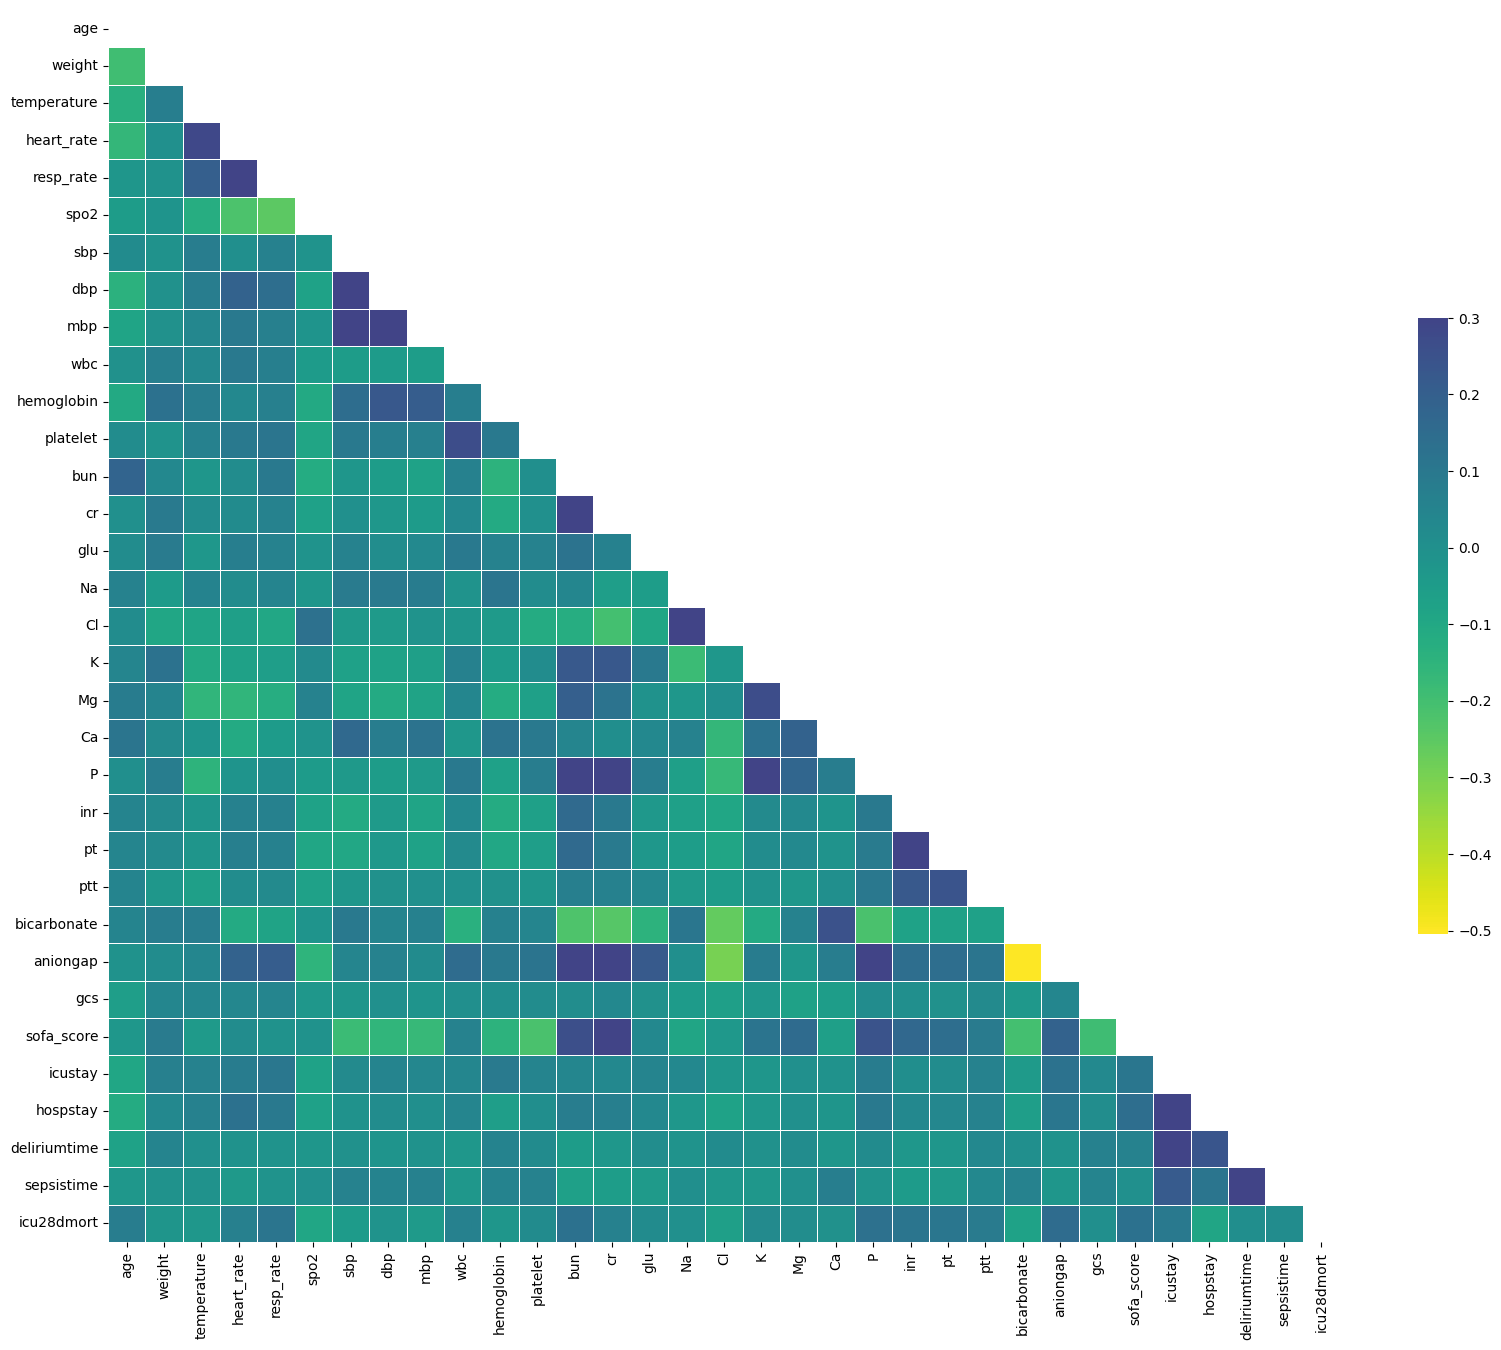

In [11]:
corr = data_table.corr(method='pearson') #method kan aangepast worden naar 'kendall' of 'spearman', zou leuk zijn als dit interactief kan op de dashboard
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 16))
cmap = sns.color_palette("viridis_r", as_cmap=True)
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)

## **Confusion Matrix** <a class="anchor" id="2.2"></a>

Deze matrix geeft aan hoe vaak het model een correcte/incorrecte voorspelling doet. Bijv. in dit geval kan je aflezen dat in de 3,845 gevallen van SAD, het model 1,065 keer een incorrecte voorspelling en 2,780 keer een correcte voorspelling gedaan heeft.

Als er een matrix van de train set en de huidige set te zien is kan het verschil geïnterpreteerd worden als een mate van data drift.

In [12]:
xgb_matrix_full = xgb.DMatrix(data.loc[:, ~data.columns.isin(["sad"])], label=data["sad"])

[[5656 1695]
 [1065 2780]]


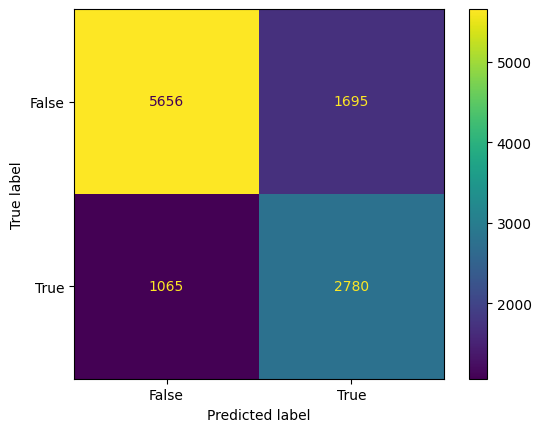

In [13]:
# het idee is dat deze er twee keer in staat: een keer met de oorspronkelijke testset en een keer met de set die op dat moment aan de app gekoppeld zit

xgb_pred_prob = model.predict(xgb_matrix_full) # dit is voor de volledige set. vervang `xgb_matrix_full` als je de performance van het model wrt een andere set wilt.
xgb_pred = np.where(xgb_pred_prob > 0.5, 1, 0)
xgb_pred_factor = pd.factorize(xgb_pred)[0]
test_sad_factor = pd.factorize(data["sad"])[0]

confusion_matrix = metrics.confusion_matrix(xgb_pred_factor, test_sad_factor)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

## **XGB Functionality** <a class="anchor" id="2.3"></a>

### **Feature importance** <a class="anchor" id="2.3.1"></a>

De volgende grafieken duiden aan in hoe verre bepaalde features invloed hebben op het model, op basis van:
- `gain`: de gemiddelde informatiewinst (relatieve entropie) van de splits waarin de respectievelijke feature voorkomt. Een 'split' kan gezien worden als een 'keuze' binnen de keuzeboom.
- `weight`: het totaal aantal splits waarin de respectievelijke feature voorkomt in alle trees.
- `cover`: gemiddelde van de 'coverage' van splits waarin de respectievelijke feature voorkomt, waarbij coverage is gedefinieerd als het aantal voorspellingen die beinvloed worden door de die split.

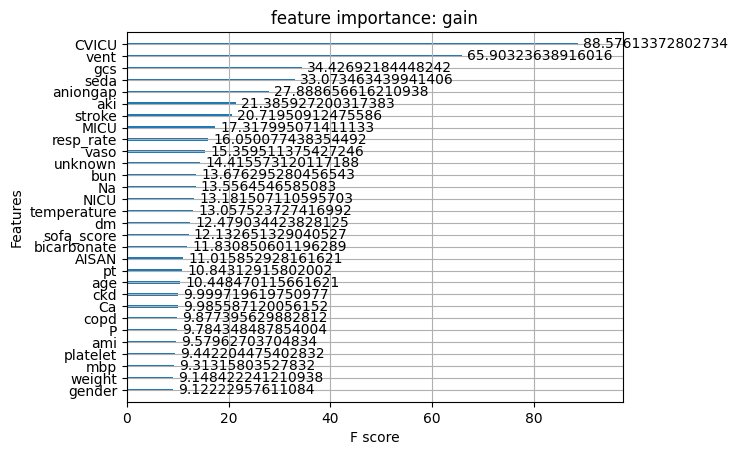

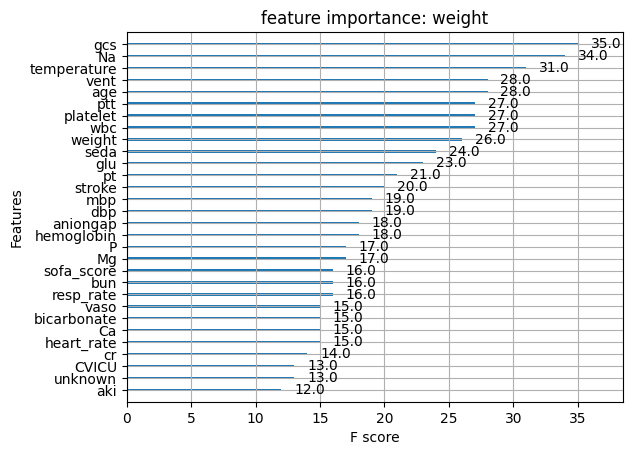

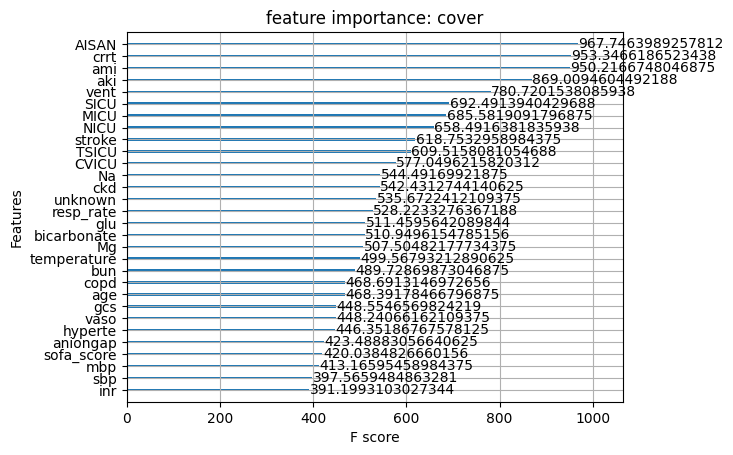

In [14]:
xgb.plot_importance(model, importance_type='gain', max_num_features=30)
plt.title('feature importance: gain')
plt.show()
xgb.plot_importance(model, max_num_features=30)
plt.title('feature importance: weight')
plt.show()
xgb.plot_importance(model, importance_type='cover', max_num_features=30)
plt.title('feature importance: cover')
plt.show()

### **Graphviz tree visualiser** <a class="anchor" id="2.3.2"></a>

Een graaf visualisatie van één tree in het XGBoost model; het model bestaat uit een groot aantal van dit soort keuzebomen. In het voorbeeld staat een visualisatie van de meest representatieve boom, maar andere trees kunnen ook worden weergegeven.

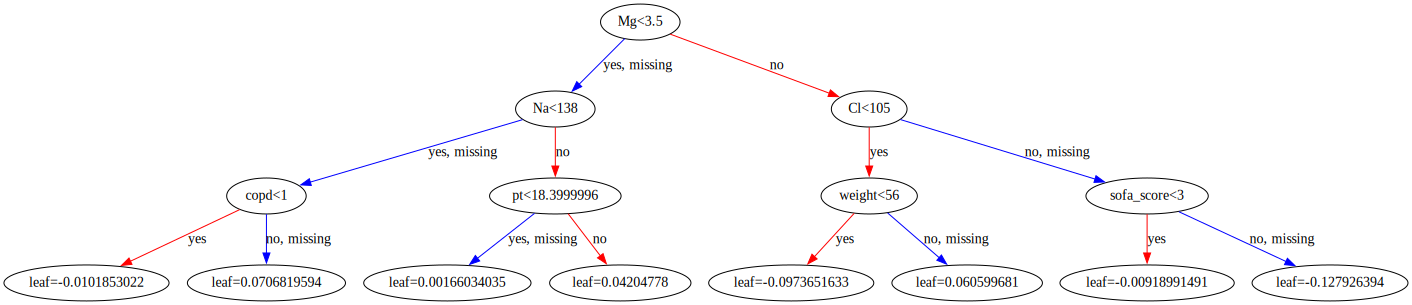

In [15]:
xgb.to_graphviz(model, num_trees=model.best_iteration) # je kan ook andere trees visualiseren door `model.best_iteration` te vervangen voor een getal (int), zou top zijn als dit interactief kan op het dashboard

### **SHAP** <a class="anchor" id="2.4"></a>
Uit de SHAP documentatie: 
> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

Kort gezegd: bij elke voorspelling kunnen we een Shapley-waarde voor iedere feature bepalen, deze waarde is een indicatie voor de mate waarin de feature heeft bijgedragen aan deze individuele voorspelling.

**wat kan ik met shap waarde**


### **Interactive Plot** <a class="anchor" id="2.4.1"></a>

Deze plot laat een sample uit de data (in het voorbeeld n = 500) zien over de twee gekozen assen. De plot lijkt aanvankelijk enigszins intimiderend, maar met wat intuïtie komt men er wel uit.

De dropdown aan de linkerkant van de grafiek bepaald de y-as, er kan gekozen worden voor:
- f(x): de cumulatieve SHAP waarde
- feature effects: de SHAP waarde van die specifieke feature

De dropdown boven de grafiek bepaald het groeperen en sorteren van de samples over de x-as. De eerste drie opties (similarity, output value, original) groeperen niet maar sorteren op de aangegeven volgorde. De feature specifieke opties groeperen de samples op elke unieke waarde van deze feature, en sorteren vervolgens deze groepen op volgorde van diens waarde in deze feature. 

Rood in in de grafiek duidt op een positieve bijdrage aan de uitkomst en blauw een negatieve. Er kan ook op een plotpunt geklikt worden, dan geeft het de index van de betreffende patient, of de index van één van de patiënten binnen een groep wanneer voor de x-as een feature geselecteerd is.

Enkele voorbeelden: 
- Als we de x-as op 'sofa_score' zetten en de y-as op 'f(x)' dan zien we dat, binnen deze sample, de kans het grootst is op SAD bij een sofa score van 10. Wanneer we bij de '10' hoveren met de muis zien we dat de groep met deze score 3 groot is. Ook zien we dan de gemiddelden van een aantal features binnen deze groep, en dat 'vent' het meest positief bijdraagt en 'gcs' het meest negatief. 
- Als we de x-as op 'sample order by output value' en de y-as op 'vent effects' dan zien we dat patiënten met een een lagere outputwaarde (dus mensen die geen SAD hebben) minder vaak aan de beademing zitten.

In [16]:
# kan zeker in het data-analysten scherm
shap.force_plot(
    explainer.expected_value, 
    shap_values[:500, :], 
    data.loc[:, ~data.columns.isin(["sad"])].iloc[:500, :],
    plot_cmap=["#FDE725", "#440154"]
)
# `500` kan aangepast worden voor een groter/kleiner sample, let wel dat een te grote sample veel lag meebrengt
# er kan ook een lijst met indices worden meegegeven als we een specifiek groepje patiënten willen vergelijken

### **Summary plot - Bar**<a class="anchor" id="2.4.2"></a>

Deze plot is vergelijkbaar met de feature importance plots, maar dan dus op basis van de gemiddelde SHAP waarden van de feature

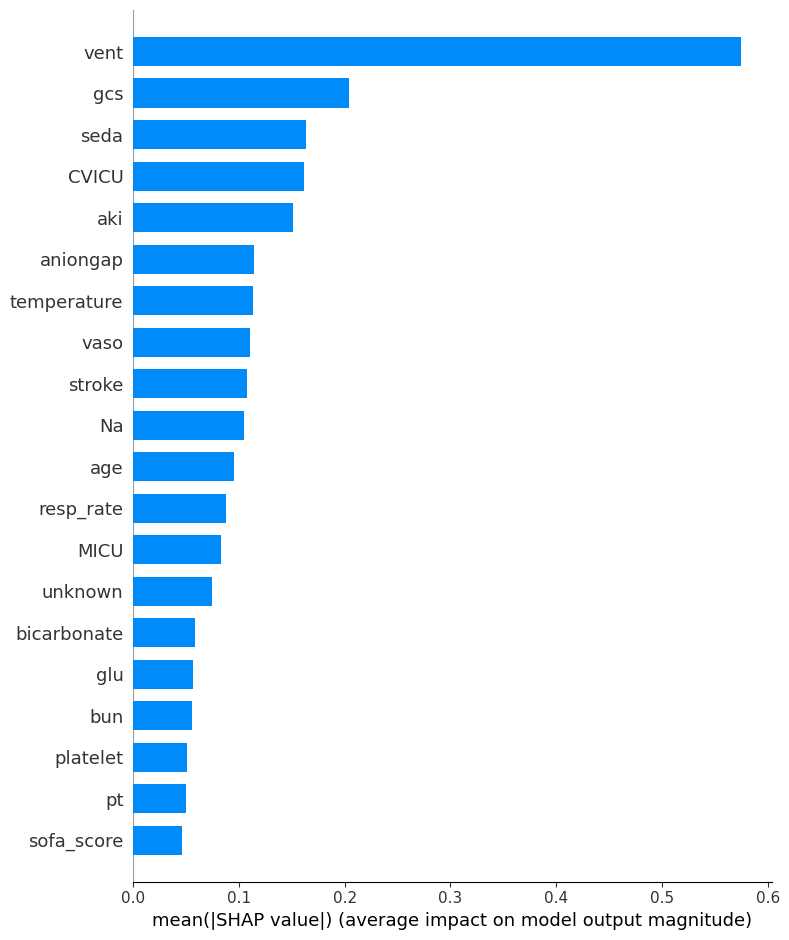

In [17]:
shap.summary_plot(shap_values, data.loc[:, ~data.columns.isin(["sad"])], plot_type="bar")

### **Summary plot - Beeswarm** <a class="anchor" id="2.4.3"></a>

De 'beeswarms' (of, sina plots) geven de dichtheid van datapunten rond bepaalde SHAP waarden van de respectievelijke feature aan. De kleur geeft de waarde van de feature zelf aan. Je kan hieruit aflezen wat voor soort waarden de features aan moeten nemen voor een grote impact op het model, en ook hoe vaak dit voor komt. Bijvoorbeeld: bij de feature 'Na' zien we bij hoge SHAP een dunne, fel rode lijn. Dit betekent dat bij een hoog 'Na' gehalte we een grote positieve invloed op de uitkomst van het model kunnen verwachten, maar dat dit niet vaak voorkomt. Aan de andere kant van de 'Na' beeswarm, net iets onder een SHAP-waarde van 0, is de sina vrij dik en blauw. Dit laat zien dat een relatief lage 'Na' waarde een licht negatieve invloed heeft op de uitkomst, maar dat dit erg vaak voor komt.

Je kan de bar summary plot zien als een compacte versie van deze plot: als we de absolute van de SHAP waarden in deze plot nemen (dus de alles aan de linker kant van de 0 lijn als het ware spiegelen), en vervolgens het gemiddelde van de beeswarms nemen, dan krijg je de bovenstaande bar plot.

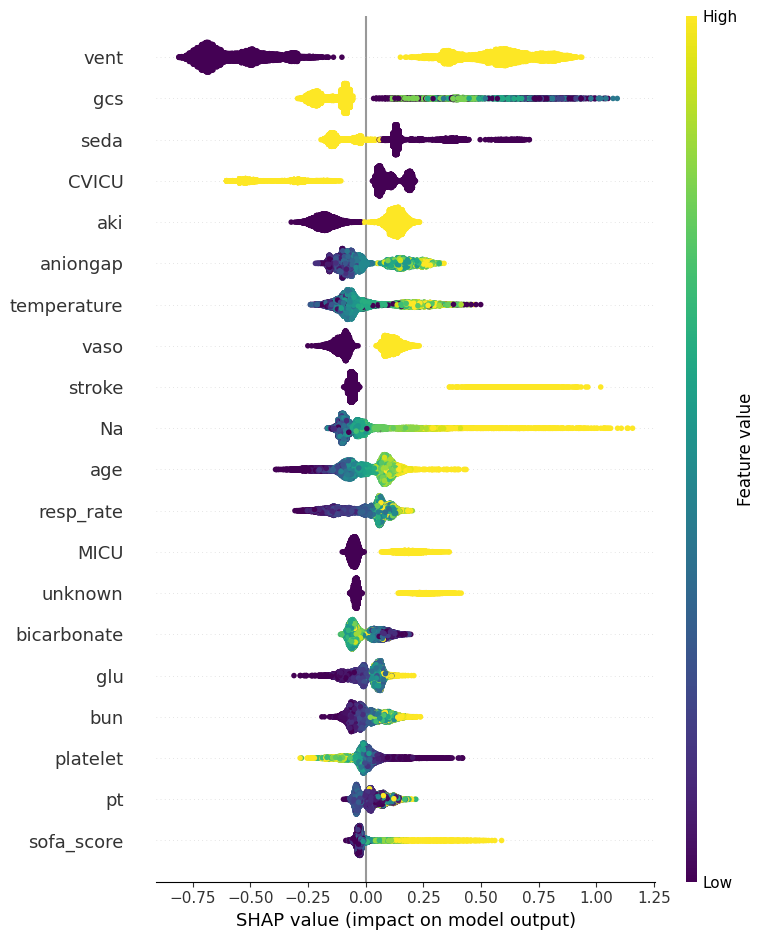

In [18]:
shap.summary_plot(shap_values, data.loc[:, ~data.columns.isin(["sad"])], cmap=plt.get_cmap("viridis"))

### **Partial dependence plots** <a class="anchor" id="2.4.4"></a>

Om in te zoomen op de effectiviteit kunnen we kijken naar partial dependence plots. In de onderstaande plot zien we op de x as de waarde van de betreffende feature, en op de y as de verwachtingswaarde (gewogen gemiddelde) van de voorspelling bij die x-waarde. De horizontale stippellijn is de verwachtinswaarde van de voorspellingen op de volledige dataset, en de verticale die van de betreffende feature. de lichtgekleurde staven op de achtergrond zijn een histogram van de dataset op basis van de feature.

In het voorbeeld kijken we naar de partial dependence van 'gcs'. We zien dat de verwachtingswaarde het hoogst is bij een 'gcs' tussen de 10 en 12, dat wil zeggen dat iemand het meeste kans op SAD heeft wanneer 'gcs' tussen de 10 en 12 zit.

Deze plot is verder niet gebaseerd op SHAP, maar als we de relatie tussen 'gcs' en de bijbehorende SHAP-waarden plotten, zien we hoe goed die overeenkomen.

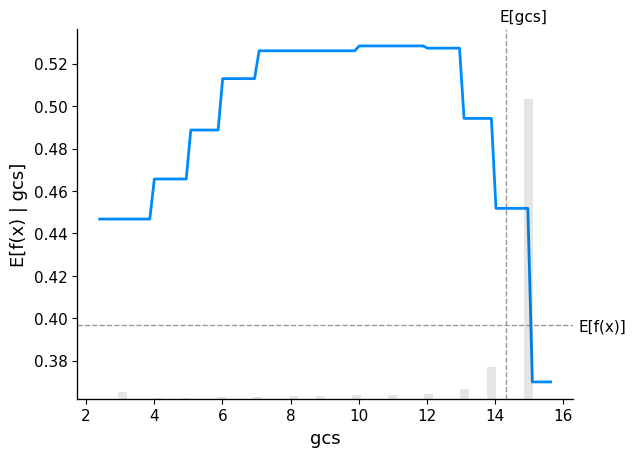

In [19]:
shap.partial_dependence_plot(
    "gcs",  # 'gcs' kan worden vervangen voor een andere feature om die te bekijken
    lambda X: model.predict(xgb.DMatrix(X.drop(['sad'], axis=1))),
    data,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

Zoals al gezegd is deze plot qua functie vergelijkbaar met de vorige.

Deze plot zegt echter ook iets over de relatie van de betreffende feature met andere features. In dit voorbeeld zien we dat wanneer de SHAP waarde voor 'gcs' relatief laag is, de patient vaak aan de beademing zit, echter bij de allerhoogste waarden die 'gcs' aanneemt dit effect omgekeerd is.

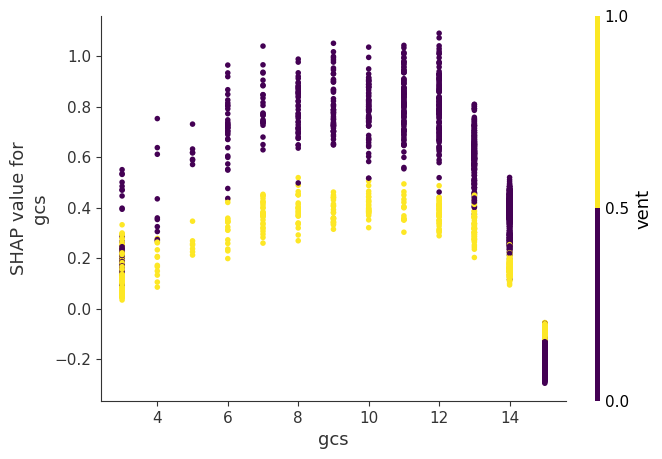

In [20]:
shap.dependence_plot(
    'gcs', # 'gcs' kan worden vervangen voor een andere feature om die te bekijken
    shap_values, 
    data.loc[:, ~data.columns.isin(["sad"])],
    cmap=plt.get_cmap("viridis")
    # interaction_index=None
) # `interaction_index=None` kan in-gecomment worden om de kleur weg te halen. 
  # Ook kan `None` vervangen worden door een feature naam (of index) om handmatig de feature waarmee we vergelijken te kiezen. 
  # het zou wellicht leuk zijn als dit interactief kan op het dashboard

Nog een voorbeeld van dezelfde plot op een andere feature: we zien hier dat 'aniongap' negatief correleert met 'bicarbonate'. Dit kan een indicatie zijn dat de een een proxy is voor de ander.

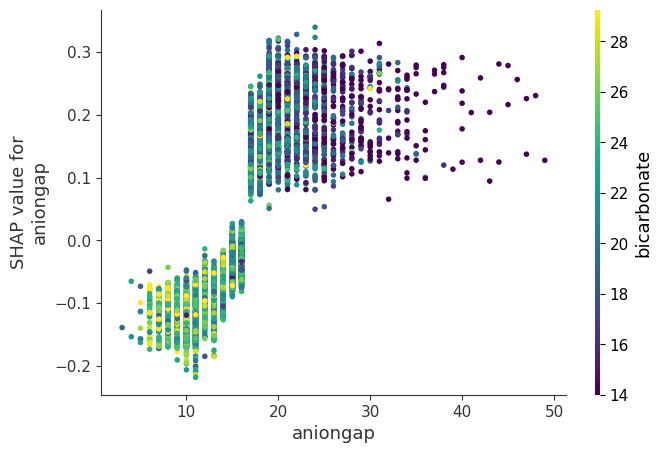

In [21]:
shap.dependence_plot(
    'aniongap', # 'gcs' kan worden vervangen voor een andere feature om die te bekijken
    shap_values, 
    data.loc[:, ~data.columns.isin(["sad"])],
    interaction_index='bicarbonate',
    cmap=plt.get_cmap("viridis")
)

## **Data Drift** <a class="anchor" id="2.5"></a>
Maakt duidelijk in hoeverre het model afwijkt van de huidige werkelijkheid 

In [22]:
data_drift_dataset_report = Report(metrics=[
    DatasetDriftMetric(),
    DataDriftTable(),    
])

# voor het voorbeeld heb ik gwn de data in tweeën gesplitst, in de code moet 'reference_data' de data zijn waar het model op is getraind en 'current_data' de set die op dat moment aan de applicatie hangt
data_drift_dataset_report.run(reference_data=data[:int(data.shape[0]/2)], current_data=data[int(data.shape[0]/2):])
data_drift_dataset_report


# **LOCAL EXPLANATIONS** <a class="anchor" id="3"></a>

## **Certainty score** <a class="anchor" id="3.3"></a>

In [23]:
# vervang '1' voor de index van de respectievelijke patient
score = model.predict(xgb.DMatrix(data.loc[[1], ~data.columns.isin(["sad"])], label=data["sad"]))[0]
if score < 0.5: score = 1-score
print("Certainty score: " + str(round(score*100, 2)) + "%")

Certainty score: 63.03%


## **Outlier detection**

In [24]:
data_cf.shape

(11196, 42)

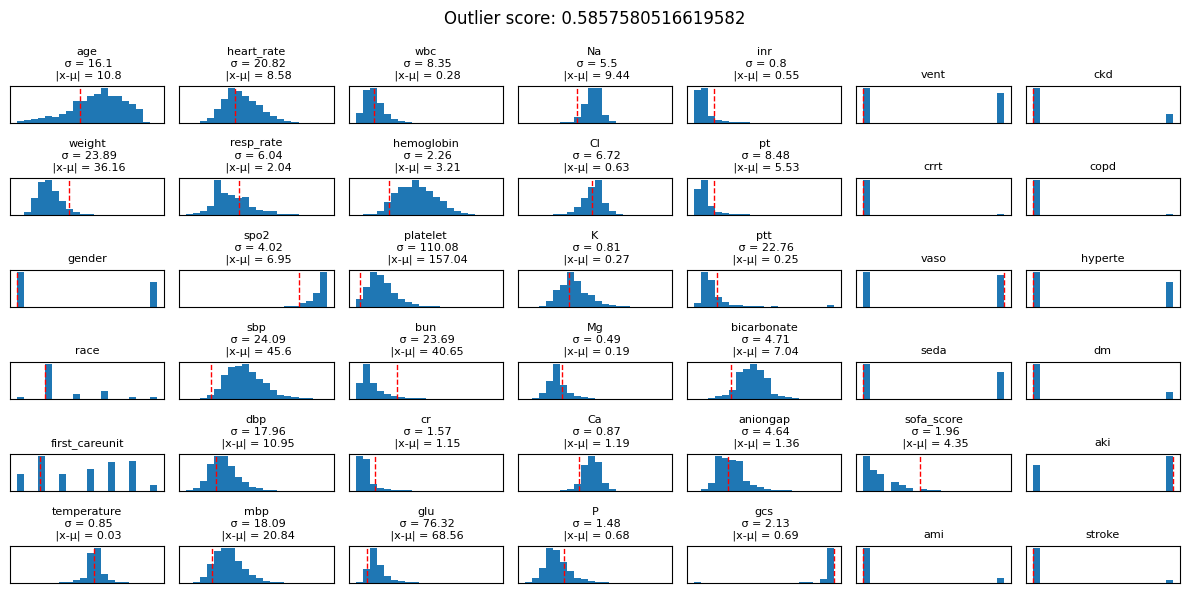

In [25]:
record = data_cf.iloc[1]
is_categorical = ['race', 'first_careunit', 'vent', 'ckd', 'crrt', 'copd', 'gender', 'vaso', 'hyperte', 'seda', 'dm', 'aki', 'ami', 'stroke']

fig, axs = plt.subplots(6, 7, figsize=(12, 6))
i = 0
j = 0
score = 0

for c in data_cf.columns:
    axs[i,j].hist(data_cf[c], bins=20)
    title = c
    if c not in is_categorical:
        title = title + "\n σ = " + str(round(data_cf[c].std(), 2)) + "\n |x-μ| = " + str(round(abs(record[c] - data_cf[c].mean()), 2))
        score += (abs(record[c] - data_cf[c].mean()) / data_cf[c].std())
        
    axs[i,j].set_title(title, fontsize=8)
    axs[i,j].get_xaxis().set_visible(False)
    axs[i,j].get_yaxis().set_visible(False)
    axs[i,j].axvline(record[c], color='r', linestyle='dashed', linewidth=1)
    i+=1
    if (i%6)==0:
        i = 0
        j += 1
score /= data_cf.shape[1]
fig.suptitle("Outlier score: " + str(score))
fig.tight_layout()
plt.show()

## **Counterfactuals** <a class="anchor" id="3.1"></a>

Het globale idee van een counterfactual is om te redeneren over wat er zou zijn gebeurd als bepaalde omstandigheden anders waren geweest. Er wordt een hypothetisch scenario gecreëert waarin één of meerdere inputs worden veranderd waarvoor de voorspelling anders zou zijn.

### **Feature select**  <a class="anchor" id="3.1.1"></a>

Counterfactuals worden gegenereerd waarbij in één of meerdere vooraf bepaalde features gevariëerd wordt.

In het voorbeeld wordt er gevarieerd in de features `age`, `weight`, `temperature` en `gcs`. In de eerste cell zien we de oorspronkelijke record, daarna volgen 5 counterfactuals die hierop zijn gebaseerd. 

Aan de tabel met counterfactuals zijn een aantal kolommen toegevoegd:
- 'reg': uitkomst van het model, uitgaande van deze counterfactual record
- 'pred': True/False uitkomst gebaseerd op 'reg'
- 'fitness': fitness score aan de hand waarvan het algoritme bepaalt hoe dicht deze counterfactual bij het origineel zit. In de huidige versie is het de som van de euclidische afstanden tussen de features.

In [26]:
data.drop(['sad'], axis=1).iloc[[1]]

age      weight  gender  temperature  heart_rate  resp_rate  spo2   sbp  \
1  56.0  119.300003       0    36.720001        82.0       22.0  90.0  75.0   

    dbp   mbp   wbc  hemoglobin  platelet   bun   cr   glu     Na     Cl    K  \
1  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   

    Mg   Ca    P  inr    pt        ptt  bicarbonate  aniongap   gcs  vent  \
1  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  15.0   0.0   

   crrt  vaso  seda  sofa_score  ami  ckd  copd  hyperte   dm  aki  stroke  \
1   0.0   1.0   0.0           8  0.0  0.0   0.0      0.0  0.0  1.0     0.0   

   AISAN  BLACK  HISPANIC  OTHER  WHITE  unknown  CCU  CVICU  MICU  MICU/SICU  \
1      0      0         0      0      1        0    0      0     1          0   

   NICU  SICU  TSICU  
1     0     0      0

In [27]:
dummy_groupings = {'race':['AISAN', 'BLACK', 'HISPANIC', 'OTHER', 'WHITE', 'unknown'], 'first_careunit': ['CCU', 'CVICU', 'MICU', 'MICU/SICU', 'NICU', 'SICU', 'TSICU']}
use_feats = ['age', 'weight', 'temperature', 'gcs']
# `limit` bepaalt hoe vaak het genetisch algoritme doorlopen wordt. een hoge limit geeft counterfactuals die veel variëren maar minder op de oorspronkelijke patiënt lijken, een lage limit geeft cfs die minder variëren maar meer op de patiënt lijken.
# gezien het algoritme eerder convergeert wanneer er in minder features gevariëerd wordt, zal `limit` lager gezet moeten worden bij een kortere `use_feats`
# wellicht is het een idee om `limit` interactief te maken op het dashboard, zodat de gebruiker die zelf in kan stellen voor een gewenst resultaat.
cf_g = GeneticCounterfactual(data.drop(['sad'], axis=1), model, dummy_groupings, use_feats=use_feats, limit=1, population_size=data.drop(['sad'], axis=1).shape[0])
cf_g.generate(data.drop(['sad'], axis=1).iloc[[1]], 5)

age      weight  gender  temperature  heart_rate  resp_rate  spo2   sbp  \
0  56.0  119.449997     0.0    37.110001        82.0       22.0  90.0  75.0   
1  56.0  119.449997     0.0    37.389999        82.0       22.0  90.0  75.0   
2  55.0  119.449997     0.0    37.389999        82.0       22.0  90.0  75.0   
3  55.0  119.449997     0.0    38.439999        82.0       22.0  90.0  75.0   
4  60.0  121.500000     0.0    37.169998        82.0       22.0  90.0  75.0   

    dbp   mbp   wbc  hemoglobin  platelet   bun   cr   glu     Na     Cl    K  \
0  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   
1  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   
2  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   
3  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   
4  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   

    Mg   Ca    P  inr    pt        ptt  bicarbonate  aniongap   gcs  vent  \
0  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  14.0   0.0   
1  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  14.0   0.0   
2  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  14.0   0.0   
3  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  14.0   0.0   
4  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  14.0   0.0   

   crrt  vaso  seda  sofa_score  ami  ckd  copd  hyperte   dm  aki  stroke  \
0   0.0   1.0   0.0         8.0  0.0  0.0   0.0      0.0  0.0  1.0     0.0   
1   0.0   1.0   0.0         8.0  0.0  0.0   0.0      0.0  0.0  1.0     0.0   
2   0.0   1.0   0.0         8.0  0.0  0.0   0.0      0.0  0.0  1.0     0.0   
3   0.0   1.0   0.0         8.0  0.0  0.0   0.0      0.0  0.0  1.0     0.0   
4   0.0   1.0   0.0         8.0  0.0  0.0   0.0      0.0  0.0  1.0     0.0   

   AISAN  BLACK  HISPANIC  OTHER  WHITE  unknown  CCU  CVICU   MICU  \
0      1  False     False  False  False    False    1  False  False   
1      1  False     False  False  False    False    1  False  False   
2      1  False     False  False  False    False    1  False  False   
3      1  False     False  False  False    False    1  False  False   
4      1  False     False  False  False    False    1  False  False   

   MICU/SICU   NICU   SICU  TSICU       reg  pred   fitness  
0      False  False  False  False  0.504692  True  1.083789  
1      False  False  False  False  0.564591  True  1.213011  
2      False  False  False  False  0.557112  True  1.572067  
3      False  False  False  False  0.557112  True  2.231791  
4      False  False  False  False  0.509901  True  4.694942

### **Genetic**  <a class="anchor" id="3.1.2"></a>

Deze methode genereert op basis van een genetisch algoritme een volledig nieuwe patiënt waarvoor het model een andere voorspelling zou doen. De fictieve patiënt wordt zo gegenereerd dat die zo min mogelijk van de daadwerkelijke patiënt afwijkt.

In [28]:
data.drop(['sad'], axis=1).iloc[[1]]

age      weight  gender  temperature  heart_rate  resp_rate  spo2   sbp  \
1  56.0  119.300003       0    36.720001        82.0       22.0  90.0  75.0   

    dbp   mbp   wbc  hemoglobin  platelet   bun   cr   glu     Na     Cl    K  \
1  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   

    Mg   Ca    P  inr    pt        ptt  bicarbonate  aniongap   gcs  vent  \
1  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  15.0   0.0   

   crrt  vaso  seda  sofa_score  ami  ckd  copd  hyperte   dm  aki  stroke  \
1   0.0   1.0   0.0           8  0.0  0.0   0.0      0.0  0.0  1.0     0.0   

   AISAN  BLACK  HISPANIC  OTHER  WHITE  unknown  CCU  CVICU  MICU  MICU/SICU  \
1      0      0         0      0      1        0    0      0     1          0   

   NICU  SICU  TSICU  
1     0     0      0

In [29]:
cf_genetic = GeneticCounterfactual(data.drop(['sad'], axis=1), model, dummy_groupings, limit=10, population_size=data.shape[0])
cf_genetic.generate(data.drop(['sad'], axis=1).iloc[[1]], 5)

age      weight  gender  temperature  heart_rate  resp_rate  spo2   sbp  \
0  72.0  111.500000     0.0    36.560001        81.0       21.0  94.0  72.0   
1  50.0  126.699997     1.0    37.000000        84.0       16.0  97.0  85.0   
2  50.0  126.699997     1.0    37.000000        83.0       16.0  97.0  85.0   
3  72.0  124.949997     0.0    36.560001        90.0       22.0  97.0  72.0   
4  48.0  110.599998     1.0    37.000000        79.0       16.0  97.0  84.0   

    dbp   mbp   wbc  hemoglobin  platelet   bun   cr   glu     Na     Cl    K  \
0  55.0  67.0  19.6        10.3      40.0  72.0  1.1  81.0  129.0  106.0  3.9   
1  55.0  61.0  12.1         7.6      36.0  73.0  1.3  84.0  130.0  102.0  3.3   
2  55.0  61.0  12.1         7.6      36.0  74.0  1.3  84.0  130.0   94.0  3.3   
3  55.0  61.0  12.1         9.6      31.0  72.0  2.3  81.0  123.0  101.0  3.4   
4  62.0  61.0  12.1         7.6      36.0  73.0  1.3  84.0  130.0  102.0  3.3   

    Mg   Ca    P  inr         pt        ptt  bicarbonate  aniongap   gcs  \
0  1.8  7.9  4.0  1.4  20.299999  37.200001         15.0      15.0  14.0   
1  1.4  9.7  3.2  1.1  13.600000  32.400002         20.0      17.0  15.0   
2  2.2  8.4  3.2  1.1  17.900000  32.400002         20.0      17.0  15.0   
3  1.8  8.4  0.9  1.8  20.299999  37.200001         20.0      14.0  15.0   
4  1.4  8.4  3.2  1.3  13.600000  32.400002         20.0      16.0  15.0   

   vent  crrt  vaso  seda  sofa_score  ami  ckd  copd  hyperte   dm  aki  \
0   1.0   0.0   0.0   1.0         7.0  0.0  0.0   0.0      0.0  0.0  1.0   
1   1.0   0.0   0.0   0.0         3.0  0.0  0.0   0.0      1.0  0.0  0.0   
2   1.0   0.0   0.0   0.0         3.0  0.0  0.0   0.0      1.0  0.0  1.0   
3   1.0   0.0   1.0   0.0         4.0  0.0  0.0   0.0      1.0  0.0  1.0   
4   1.0   0.0   1.0   0.0         3.0  0.0  0.0   0.0      1.0  0.0  0.0   

   stroke  AISAN  BLACK  HISPANIC  OTHER  WHITE  unknown    CCU  CVICU  MICU  \
0     0.0  False  False     False  False      0    False  False  False     1   
1     1.0  False  False     False  False      1    False  False  False     0   
2     1.0  False  False     False  False      1    False  False  False     0   
3     0.0  False  False     False  False      0    False  False  False     0   
4     1.0  False  False     False  False      1    False  False  False     0   

   MICU/SICU   NICU   SICU  TSICU       reg  pred    fitness  
0      False  False  False  False  0.685672  True  22.003765  
1      False  False  False  False  0.703455  True  22.097925  
2      False  False  False  False  0.709303  True  22.542367  
3      False  False  False  False  0.698935  True  23.325052  
4      False  False  False  False  0.721635  True  23.378590

### **KDTree**  <a class="anchor" id="3.1.3"></a>

Deze methode zoekt in de dataset, aan de hand van een KDTree algoritme, een bestaande patiënt waarvoor het model een andere voorspelling zou doen. De nieuwe patiënt wordt zo gekozen dat die zo min mogelijk van de huidige patiënt afwijkt.

de nieuwe kolom 'dst' geeft de euclidische afstand tussen de counterfactual en het origineel aan, het is dus vergelijkbaar met 'fitness' in de vorige.

In [30]:
data.drop(['sad'], axis=1).iloc[[1]]

age      weight  gender  temperature  heart_rate  resp_rate  spo2   sbp  \
1  56.0  119.300003       0    36.720001        82.0       22.0  90.0  75.0   

    dbp   mbp   wbc  hemoglobin  platelet   bun   cr   glu     Na     Cl    K  \
1  56.0  61.0  13.0         7.2      36.0  70.0  2.7  83.0  128.0  103.0  4.0   

    Mg   Ca    P  inr    pt        ptt  bicarbonate  aniongap   gcs  vent  \
1  2.2  7.0  4.5  2.1  22.4  38.400002         15.0      14.0  15.0   0.0   

   crrt  vaso  seda  sofa_score  ami  ckd  copd  hyperte   dm  aki  stroke  \
1   0.0   1.0   0.0           8  0.0  0.0   0.0      0.0  0.0  1.0     0.0   

   AISAN  BLACK  HISPANIC  OTHER  WHITE  unknown  CCU  CVICU  MICU  MICU/SICU  \
1      0      0         0      0      1        0    0      0     1          0   

   NICU  SICU  TSICU  
1     0     0      0

In [31]:
cf_kdtree = KDTreeCounterFactual(data.drop(['sad'], axis=1), model)
cf_kdtree.generate(data.drop(['sad'], axis=1).iloc[[1]], 5)

age      weight  gender  temperature  heart_rate  resp_rate   spo2  \
2912   62.0  103.000000       0    33.200001        78.0       16.0   97.0   
6348   69.0  104.000000       1    36.500000        93.0       31.0   93.0   
12476  54.0  143.500000       0    36.610001        82.0        8.0   98.0   
6652   62.0   94.500000       1    36.560001        92.0       26.0   99.0   
792    75.0  105.900002       0    36.560001        83.0       20.0  100.0   

         sbp   dbp   mbp   wbc  hemoglobin  platelet    bun   cr    glu  \
2912    89.0  51.0  58.0  10.9         8.1      55.0  101.0  8.6   70.0   
6348    71.0  43.0  50.0   0.9        11.5      37.0   38.0  3.0  101.0   
12476   83.0  42.0  49.0   7.1         9.5      36.0   68.0  2.3  118.0   
6652    89.0  43.0  55.0   6.7         7.2      67.0   43.0  2.7   68.0   
792    103.0  66.0  77.0   1.1         9.3      61.0   76.0  2.4  108.0   

          Na     Cl    K   Mg   Ca    P  inr         pt        ptt  \
2912   138.0  105.0  4.9  2.9  7.9  6.6  2.5  27.200001  45.900002   
6348   136.0  103.0  6.1  2.3  8.9  9.7  1.6  18.100000  37.400002   
12476  135.0  101.0  5.2  2.3  8.6  6.0  3.1  34.799999  47.200001   
6652   133.0  107.0  4.6  1.9  7.1  4.2  2.2  22.600000  38.599998   
792    139.0  101.0  4.4  2.6  7.7  4.5  1.4  15.500000  21.400000   

       bicarbonate  aniongap   gcs  vent  crrt  vaso  seda  sofa_score  ami  \
2912          17.0      21.0   4.0   0.0   0.0   1.0   0.0           8  0.0   
6348          15.0      28.0  12.0   1.0   1.0   1.0   1.0           3  1.0   
12476         26.0      13.0  12.0   0.0   0.0   1.0   0.0           4  0.0   
6652          17.0      14.0  15.0   1.0   0.0   1.0   1.0           6  0.0   
792           23.0      15.0  15.0   1.0   0.0   0.0   0.0           5  0.0   

       ckd  copd  hyperte   dm  aki  stroke  AISAN  BLACK  HISPANIC  OTHER  \
2912   0.0   0.0      0.0  0.0  1.0     0.0      0      0         0      0   
6348   1.0   0.0      0.0  1.0  1.0     0.0      0      0         0      0   
12476  0.0   0.0      0.0  0.0  1.0     0.0      0      0         0      0   
6652   0.0   0.0      1.0  0.0  1.0     0.0      0      0         0      0   
792    0.0   0.0      0.0  0.0  1.0     1.0      0      0         0      0   

       WHITE  unknown  CCU  CVICU  MICU  MICU/SICU  NICU  SICU  TSICU  \
2912       1        0    0      0     1          0     0     0      0   
6348       0        1    0      0     0          0     0     0      1   
12476      1        0    0      0     1          0     0     0      0   
6652       1        0    0      0     1          0     0     0      0   
792        1        0    1      0     0          0     0     0      0   

            reg  pred        dst  
2912   0.870129  True  50.399212  
6348   0.841014  True  52.857719  
12476  0.681989  True  54.418489  
6652   0.650931  True  57.073599  
792    0.645523  True  61.315624

## **SHAP** <a class="anchor" id="3.2"></a>

### **Force plot** <a class="anchor" id="3.2.1"></a>

Deze plot laat zien in hoe verre bepaalde features hebben bijgedragen aan de voorspelling. Een blauwe feature draagt negatief bij aan de voorspelling en een rode positief. Een langer balkje indiceert dat een feature meer bijgedragen heeft. 'f(x)' is de gemiddelde SHAP-waarde van deze voorspelling, en 'base value' is de verwachtingswaarde van alle SHAP-waarden in de set.

In [32]:
row = 0  # `row` is de index van de huidige patient
shap.force_plot(explainer.expected_value, shap_values[row, :], data.loc[:, ~data.columns.isin(["sad"])].iloc[row, :], plot_cmap=["#FDE725", "#440154"])

### **Waterfall** <a class="anchor" id="3.2.3"></a>

De waterfall-plot is eigenlijk hetzelfde als de vorige maar dan staat elke feature los, en op volgorde van importance. Dit kan wat overzichtelijker zijn.

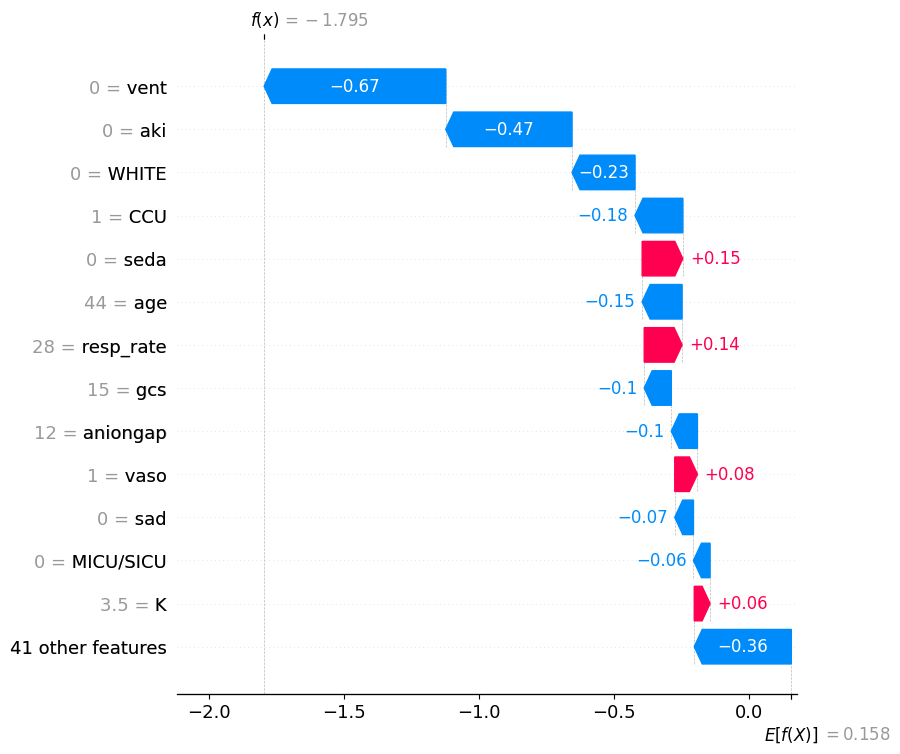

In [33]:
# De SHAP-waarden in deze wijken iets af van de andere visualisaties, dit is omdat de rest is gebaseerd op `TreeExplainer` en deze `Explainer` van de SHAP library. 
# Deze plot kan het best achterwege gelaten worden omdat:
# - Kleuren kunnen niet veranderd worden
# - De plot kan niet op een TreeExplainer gemaakt worden
# - De plot komt toch al erg overeen met de decision plots
# de eerste twee punten kunnen overkomen worden door buiten de library te werken, maar dit lijkt de moeite niet waard

shap.plots.waterfall(shap_waterfall[0], max_display=14)

### **Decision plots** <a class="anchor" id="3.2.2"></a>

Deze is vergelijkbaar met de waterfall-plot. Als we van beneden naar boven de lijn volgen zien we hoe iedere feature de uitkomst beinvloedt. 

De decision plot wijkt wel af van de waterfall-plot in dat we op de x-as niet de cumulatieve SHAP waarde hebben, maar de uitkomst van het model (boven 0.5 is de voorspelling SAD, en daaronder NON-SAD). De grijze lijn is het gewogen gemiddelde van alle voorspellingen op de set.

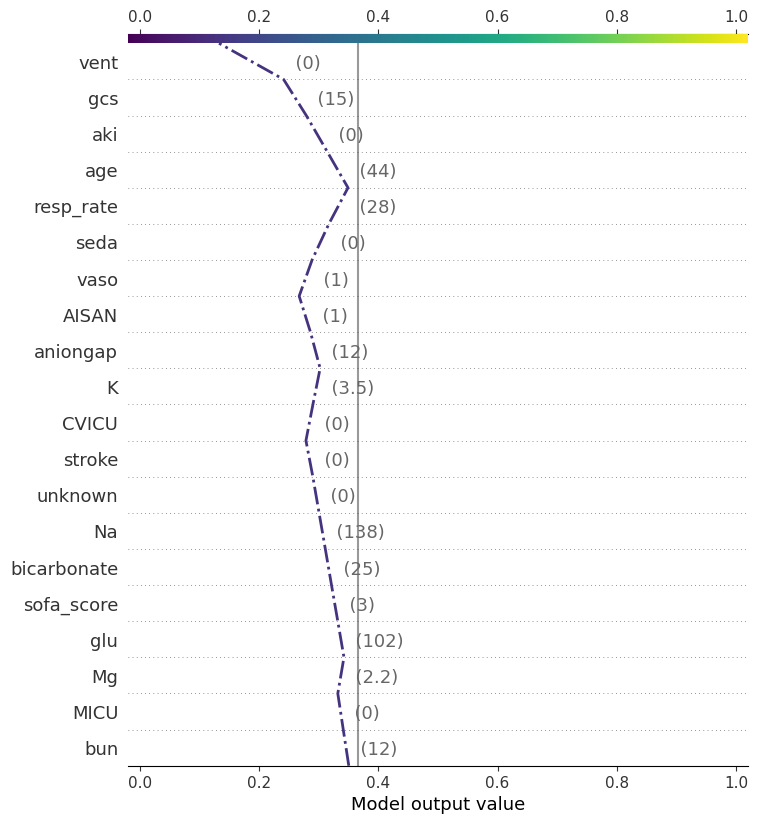

In [34]:
row = 0
shap.decision_plot(
    explainer.expected_value,
    shap_values[row, :],
    data.loc[:, ~data.columns.isin(["sad"])].iloc[0, :],
    link="logit",
    highlight=0,
    plot_color=plt.get_cmap("viridis")
)

Hier is de decision plot uitgebreid om de patiënt te vergelijken met andere patiënten naar keuze, in dit geval de eerste 5 patiënten uit de dataset

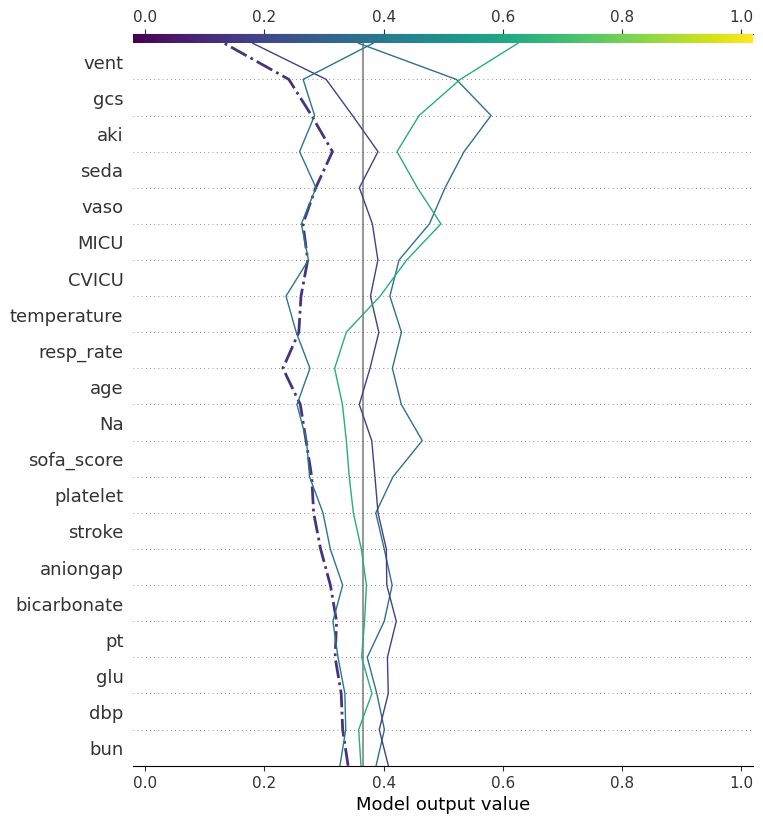

In [35]:
row_current = 0
rows = [0,1,2,3,4]  # indices van de patienten waarmee we de huidige patient willen vergelijken

shap.decision_plot(
    explainer.expected_value, 
    shap_values[rows, :], 
    data.loc[:, ~data.columns.isin(["sad"])].iloc[0, :],
    link="logit", 
    highlight=row_current,
    plot_color=plt.get_cmap("viridis")
)

We kunnen de interactieve plot ook gebruiken voor locale uitleg; hieronder de interactieve plot voor de zelfde 5 patiënten als de vorige plot.

In [36]:
shap.force_plot(
    explainer.expected_value, shap_values[[0,1,2,3,4], :], plot_cmap=["#FDE725", "#440154"]
)